# Prepare notebook

In [1]:
import json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from plotting_utilities import *

# Import data

In [2]:
books = pd.read_pickle('2019112_goodreads_book_data.pkl')
shelves = pd.read_pickle('2019112_goodreads_book_shelves.pkl')
books = books.join(shelves)

categories = pd.read_pickle('2019112_goodreads_book_categories.pkl')
category_mappings = json.load( open("category_mappings.json","r"))
#academic_fields = pd.read_pickle('2019112_goodreads_book_academic_fields.pkl')
#academic_field_mappings = json.load( open("academic_field_mappings.json","r"))

# (Naive) Baysian probabilities
##### P(rating|category) = P(category|rating)*P(rating)/P(category)


In [7]:
P_rating = books.groupby('My Rating')['Title'].count()/len(books)
P_rating.name = 'P_rating'

In [9]:
P_category = categories.sum()/len(categories)
P_category.name = 'P_category'

In [8]:
ratings = books['My Rating'].unique()


In [25]:
index = pd.MultiIndex.from_product([ratings,categories.columns],names=['My Rating','category']) 
P_category_rating = pd.DataFrame(np.zeros((len(categories.columns)*len(ratings), 1)), 
                    index=index, columns=['P(category|rating)'])
P_category_rating = P_category_rating.sort_index()

for r in ratings:
    R = books.loc[books['My Rating']==r]
    for c in categories.columns:
        C = categories.loc[R.index, c]
        P_category_rating.loc[(r, c)] = float(sum(C))/float(len(R))


index = pd.MultiIndex.from_product([categories.columns,ratings],names=['category','My Rating']) 
P_rating_category = pd.DataFrame(np.zeros((len(categories.columns)*len(ratings), 1)), 
                    index=index, columns=['P(rating|category)'])
P_rating_category = P_rating_category.sort_index()

for c in categories.columns:
    for r in ratings:
        P_rating_category.loc[(c, r)] = (P_category_rating.loc[(r,c)]*P_rating.loc[r]/P_category.loc[c]).values                              

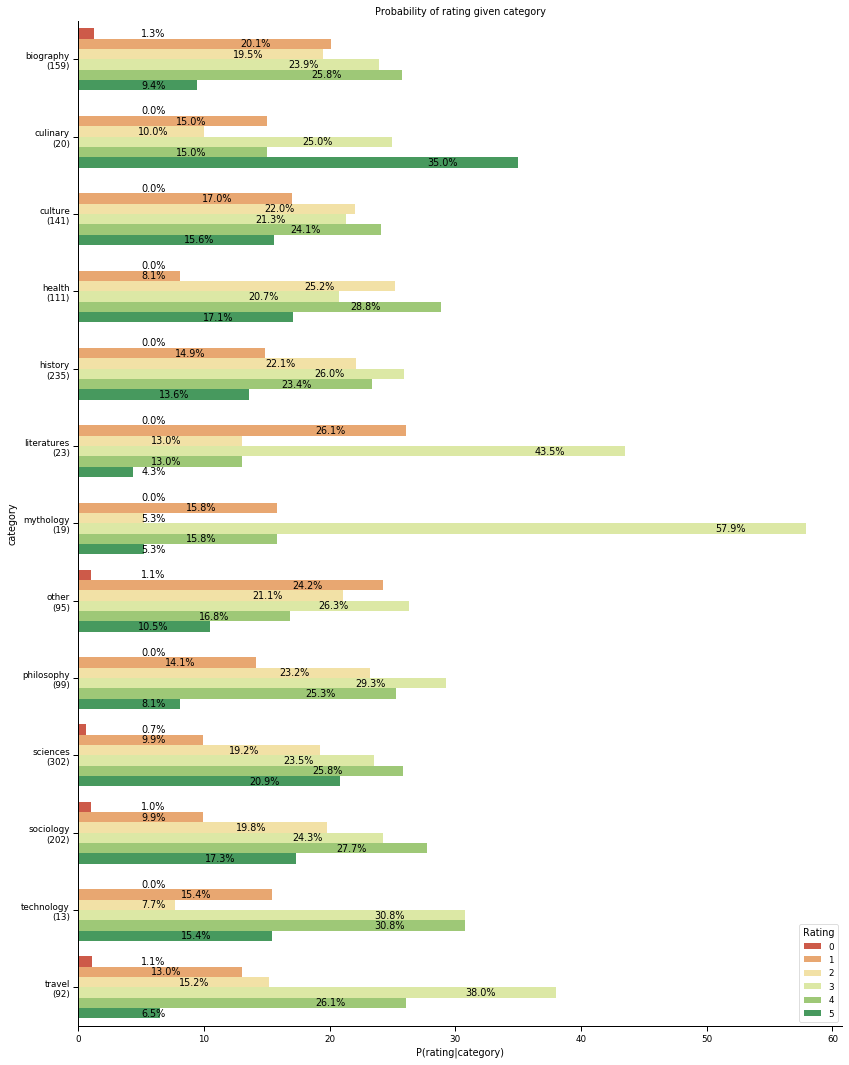

In [36]:
sns.set_context("paper", font_scale=1)
sns.set_palette('deep')
g = sns.catplot(data = (P_rating_category*100.).reset_index(), x = 'P(rating|category)', y = 'category', hue = 'My Rating', kind = 'bar', 
                   aspect = .8, height=15, palette='RdYlGn', legend = False)

g.ax.set_title('Probability of rating given category')
plt.legend(loc='lower right', title = 'Rating')
plt.tight_layout(pad=1.5, w_pad=0.5, h_pad=0.5)

for p in g.ax.patches:
    try:
        g.ax.annotate("%.1f%%" %(p.get_width()), (max(6.,p.get_width()-6), p.get_y() + p.get_height() / 2.), ha='center', va='center')
    except:
        g.ax.annotate(".1f%%" %(0.), (0.5, p.get_y() + p.get_height() / 2.), ha='center', va='center')
        continue
y_ticklabels = []
for c,y in [(item.get_text(),item.get_position()) for item in g.ax.get_yticklabels()] :
    count = sum(categories[c])
    y_ticklabels = y_ticklabels+['%s\n(%d)' %(c, count)]
g.ax.set_yticklabels(y_ticklabels);   

plt.savefig('P(rating|category)',bbox_inches='tight',pad_inches=1., dpi=300)

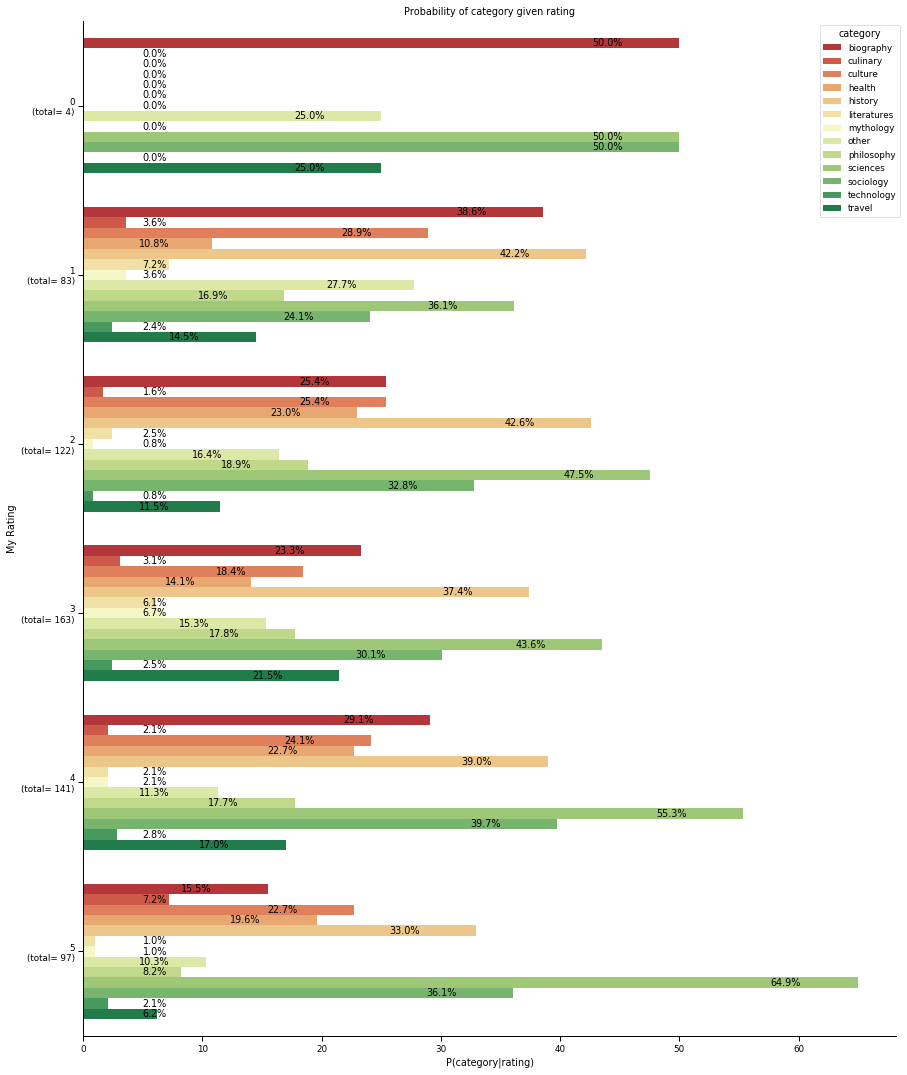

In [41]:
sns.set_context("paper", font_scale=1)
g = sns.catplot(data = (P_category_rating*100.).reset_index(), x = 'P(category|rating)', y = 'My Rating', hue = 'category', kind = 'bar', 
                   aspect = 0.8, height=15, palette='RdYlGn', legend = False, orient = 'horizontal')

g.ax.set_title('Probability of category given rating')
plt.legend(bbox_to_anchor=(1.01, 1), title = 'category')
plt.tight_layout(pad=1, w_pad=0.5, h_pad=0.5)

for p in g.ax.patches:
    try:
        g.ax.annotate("%.1f%%" %(p.get_width()), (max(6.,p.get_width()-6), p.get_y() + p.get_height() / 2.), ha='center', va='center')
    except:
        g.ax.annotate(".1f%%" %(0.), (0.5, p.get_y() + p.get_height() / 2.), ha='center', va='center')
        continue
y_ticklabels = []
for c,y in [(item.get_text(),item.get_position()) for item in g.ax.get_yticklabels()] :
    count = sum(books['My Rating']==int(c))
    y_ticklabels = y_ticklabels+['%s\n(total= %d)' %(c, count)]
g.ax.set_yticklabels(y_ticklabels); 
plt.savefig('P(category|rating)',bbox_inches='tight',pad_inches=1., dpi=300)